<a href="https://colab.research.google.com/github/lamontdobbins3-stack/DataScience/blob/main/Depression_Risk_Analysis_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Early Depression Risk Analysis (NLP)



This project analyzes large scale Reddit community discussions to identify linguistic patterns statistically associated with depression related discourse. The objective is not clinical diagnosis, but to model behavioral risk signals and understand how psychosocial distress manifests in online communication.

### Key Takeaways:


*   Depression associated language is structurally patterened.
*   Themeatic clusters include hopelessness, work and school stress, relationship strain and help seeking behavior.
*   Model captures distress related signals beyond simple sentiment.
*   Framework supports risk indication (early warning flag) not diagnosis.


Link to [Research Paper](https://docs.google.com/document/d/1sSj8ErVJNAtSnF6ycWVYcDsE6FkLN2Za_zMM7xN6Wh0/edit?usp=sharing)

See [Dataset](https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset)

In [2]:
#libraries
import pandas as pd
import numpy as np
import re
import kagglehub
from kagglehub import KaggleDatasetAdapter
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import resample
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import nltk
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
#Load Dataset
file_path = "reddit_depression_dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rishabhkausish/reddit-depression-dataset",
  file_path,
)

print("Hugging Face Dataset:", df)
print("Sanity check: ")
print(df["body"][:5])

/tmp/ipython-input-3056044993.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 431M/431M [00:08<00:00, 55.0MB/s]

Extracting zip of reddit_depression_dataset.csv...



/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


Hugging Face Dataset:         Unnamed: 0     subreddit  \
0            47951  DeepThoughts   
1            47952  DeepThoughts   
2            47957  DeepThoughts   
3            47959  DeepThoughts   
4            47960  DeepThoughts   
...            ...           ...   
2470773   10742224    depression   
2470774   10742230    depression   
2470775   10742232    depression   
2470776   10742243    depression   
2470777   10742244    depression   

                                                     title  \
0                                   Deep thoughts underdog   
1        I like this sub, there's only two posts yet I ...   
2                                                 Rebirth!   
3        "I want to be like water. I want to slip throu...   
4                                                Who am I?   
...                                                    ...   
2470773                                     Alone as usual   
2470774                              Help needed 

## Preprocessing

In [4]:
#remove useless entires
df = df.dropna(subset=["body"])

#convert epoch utc to standard
df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s")
df["year"] = df["created_dt"].dt.year
df["hour"] = df["created_dt"].dt.hour

#basic cleaning of reviews
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["body_clean"] = df["body"].apply(clean_text)

#temp dataset to prevent crashing
df_work = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=25_000, random_state=42))
      .reset_index(drop=True)
)


#Get Stopwords (industry specific) SET MY OWN AFTER
STOPWORDS = set(stopwords.words('english'))

#Preserve + Negations
NEGATIONS = {"no", "not", "never", "n't", "nor"}
PRONOUNS = {"me","them", "mine", "myself"}
TIME_WORDS = {"now","today","yesterday","tomorrow","all", "always",
              "every", "ever", "forever", "constantly", "often",
              "sometimes", "rarely"}
SOCIAL_WORDS = {"mom", "dad", "family", "friends", "friend",
             "alone", "everyone", "someone", "people"}
DOMAIN_STOPWORDS = {
    "like","get","got","go","know","one","really",
    "would","time","want","now", "all"}

# Internet slang from Log Odds below
SLANG_STOPWORDS = {
    "bruh", "boi", "bois", "yeet", "uwu",
    "pp", "nudes", "fortnite",
    "platypus", "plat", "perry",
    "nom", "frick",
    "quaran", "quara", "tined",
    "occurences",  "occurances",
    "clack", "filler", "uuo",  "ornithorhynchus", "anatinus", "duckbill", "duckbilled",
    "fillerfillerfillerfillerfillerfillerfillerfillerfiller",
    "fillet", "filer",
    "mods",
    "thot", "virgins",
    "gucci", "homies", "yuh",
    "jose", "baba",
    "hellu",
    "vr",     "monotreme", "mammal",
    "pineapple", "tangerines", "beverage",
    "commodore", "tedtalk", "lofi",
    "nnn", "poopoo",
    "oliver", "kgreen",
    "muda"
}

PRESERVE = (
    PRONOUNS
    | TIME_WORDS
    | SOCIAL_WORDS
    | NEGATIONS
)
SMART_STOPWORDS = (STOPWORDS - PRESERVE) | DOMAIN_STOPWORDS | SLANG_STOPWORDS

#remove noise from responses
texts = df_work["body_clean"].tolist()
cleaned = []

for text in texts:
    tokens = [
        word for word in text.split()
        if word not in SMART_STOPWORDS
    ]
    cleaned.append(" ".join(tokens))

df_work["body_tokenized"] = cleaned


df_work[["body","body_clean","body_tokenized"]].head(5)
df_work["body_tokenized"].str.len().describe()

/tmp/ipython-input-187382833.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=25_000, random_state=42))


,body_tokenized
count,50000.000000
mean,363.499160
std,708.566347
min,0.000000
25%,48.000000
50%,156.000000
75%,423.000000
max,39985.000000


## Exploratory Data Analysis

###### Depressed Sample


TOP 20 MOST COMMON WORDS (after stopwords)
--------------------------------------------------
[('me', 68354), ('not', 27603), ('feel', 25820), ('life', 21457), ('myself', 19920), ('no', 18358), ('even', 16941), ('people', 16477), ('never', 11832), ('them', 11227), ('think', 11170), ('going', 10987), ('friends', 10789), ('much', 10651), ('day', 9974), ('things', 9615), ('years', 9394), ('depression', 8794), ('help', 8582), ('anything', 8537)]


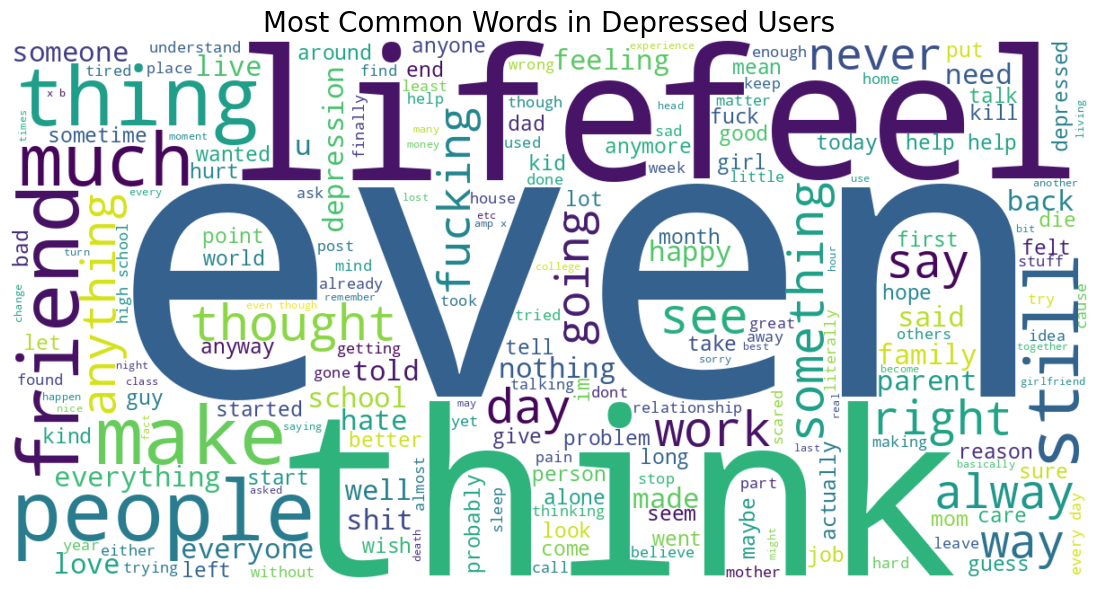


Depressed Sample
--------------------------------------------------
25000    fucking deformed accident years ago left me scarred developed body dysmorphia result no confidence anymore lost friends toxic relationship partner fucking stand work work hours day max days week cleaning office anything insane payments government every two weeks without telling them balance lack money making work yeah rort government give fuck though literally work long periods mental health survive applied disability year ago denied applied literally taking forever continue payments them tell me approved not forced proper job hours not turned life shit ever since accident everything feels used love travel new things afraid anything comfort zone getting older fatter uglier day point anymore feels fucking no jump front fucking train something literally useless society
25001                                                                                                                                           

In [5]:
#Word Frequency (depressed)
all_words_depressed = " ".join(
    df_work[df_work["label"] == 1]["body_tokenized"]).split()
freq = Counter(all_words_depressed).most_common(20)

print("\nTOP 20 MOST COMMON WORDS (after stopwords)")
print("-" * 50)
print(freq)

#Word Cloud
all_text_depressed = " ".join(df_work["body_tokenized"])

#Generate word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis"
).generate(all_text_depressed)

#Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Words in Depressed Users", fontsize=20)
plt.axis("off")
plt.show()

#Show 4 sentencess
depressed_df = df_work[df_work["label"] == 1]
print("\nDepressed Sample")
print("-" * 50)
pd.set_option("display.max_colwidth", None)
print(depressed_df["body_tokenized"].head(4))

###### Non-Depressed Sample

In [6]:
print(df_work.columns)

Index(['Unnamed: 0', 'subreddit', 'title', 'body', 'upvotes', 'created_utc',
       'num_comments', 'label', 'created_dt', 'year', 'hour', 'body_clean',
       'body_tokenized'],
      dtype='object')



TOP 20 MOST COMMON WORDS (after stopwords)
--------------------------------------------------
[('me', 15102), ('not', 6712), ('help', 5414), ('people', 4059), ('no', 3472), ('them', 3421), ('school', 3098), ('friends', 2898), ('even', 2882), ('day', 2848), ('feel', 2837), ('think', 2656), ('said', 2451), ('good', 2450), ('going', 2294), ('make', 2288), ('never', 2094), ('also', 2082), ('something', 2018), ('say', 2017)]


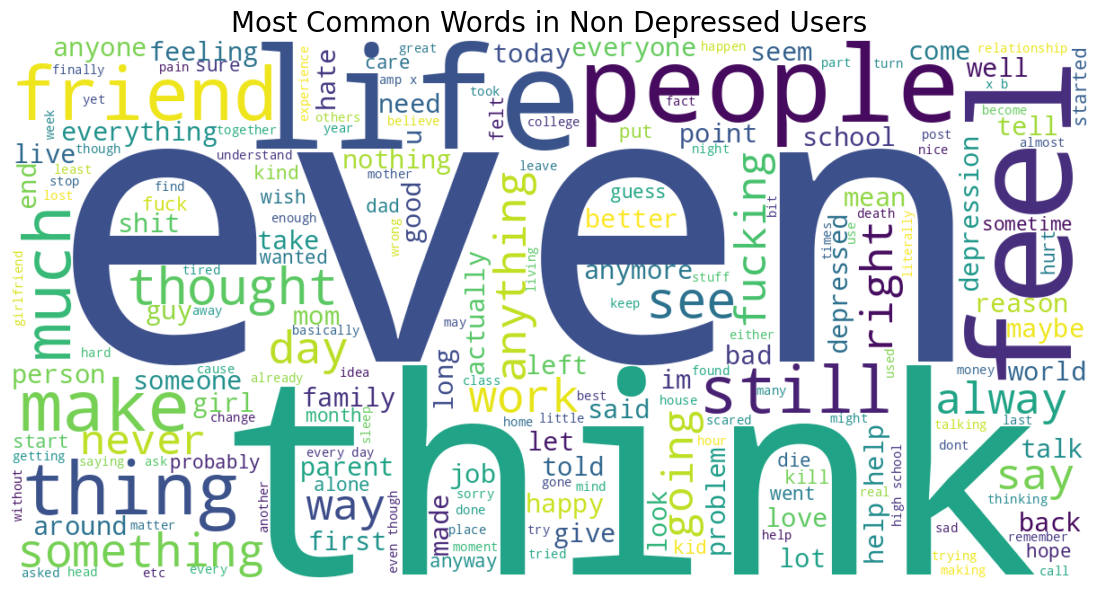


Non-Depressed Sample
--------------------------------------------------
0                                                                                                                                                                                                                                                                                                                                                                         pussied failed attempt ask f
1    sooo friend th grade moved california seventh grade started kinda lost contact talk sometimes nowhere calls me yesterday saying love ex years foster care person anymore nowwww not best emotional support since never say especially lady started talking months happening either way though gonna not best shape bad situation kinda needed chest yeah probably personal reddit not gonna share
2                                                                                                                                                

In [7]:
#Word Frequency (not-depressed)
all_words_non_depressed = " ".join(
    df_work[df_work["label"] == 0]["body_tokenized"]).split()
freq = Counter(all_words_non_depressed).most_common(20)

print("\nTOP 20 MOST COMMON WORDS (after stopwords)")
print("-" * 50)
print(freq)

#Word Cloud
all_text_non_depressed = " ".join(df_work["body_tokenized"])

#Generate word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis"
).generate(all_text_non_depressed)

#Display
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most Common Words in Non Depressed Users", fontsize=20)
plt.axis("off")
plt.show()

#Show 4 Examples
non_depressed_df = df_work[df_work["label"] == 0]
print("\nNon-Depressed Sample")
print("-" * 50)
print(non_depressed_df["body_tokenized"].head(4))

### Top 20 Words Analysis:
After heavy preprocessing of stop words and adding aditional domain words, there are still lots of vague words that do not provide much value. While there are some useful entities such as parents or friends and other valuable words for topic modeling such as "depressed", it can be inferred that due to the nature of the Reddit communities there will be lots of cross over. Instead, we will use log odds ratio to understand how much more likely certian words appear in the depressed sample vs non depressed.

*(Note - Teenager is going to be a very complex Reddit community as there may be both depressed and not depressed indiivudals in these sample. I will perform classification using K-Means later to see how closely we can predict if the post shows depressed or not depressed.)*

<br>

### Log Odds Ratio

In [8]:
#Split by label
depressed = df_work[df_work["label"] == 1]["body_tokenized"]
non_depressed = df_work[df_work["label"] == 0]["body_tokenized"]

#Convert to word lists
depressed_words = " ".join(depressed).split()
non_depressed_words = " ".join(non_depressed).split()

#Count words
depressed_counter = Counter(depressed_words)
non_depressed_counter = Counter(non_depressed_words)

total_depressed = sum(depressed_counter.values())
total_non_depressed = sum(non_depressed_counter.values())

vocab = set(depressed_counter.keys()).union(set(non_depressed_counter.keys()))
V = len(vocab)

#Calculate log odds ratio
log_odds_ratio = {}

for word in vocab:
    depressed_count = depressed_counter[word]
    non_depressed_count = non_depressed_counter[word]

    depression_prob = (depressed_count + 1) / (total_depressed + V)
    non_depression_prob = (non_depressed_count + 1) / (total_non_depressed + V)

    log_odds_ratio[word] = np.log(depression_prob / non_depression_prob)

#Top words more common in depressed
top_depressed = sorted(log_odds_ratio.items(), key=lambda x: x[1], reverse=True)[:20]

print("\nTop 20 Words More Common in Depressed Set")
print("-" * 50)
for word, score in top_depressed:
    print(f"{word:<20} {score:.4f}")

#Top words more common in non depressed
top_non_depressed = sorted(log_odds_ratio.items(), key=lambda x: x[1])[:20]

print("\nTop 20 Words More Common in Non-Depressed Set")
print("-" * 50)
for word, score in top_non_depressed:
    print(f"{word:<20} {score:.4f}")


Top 20 Words More Common in Depressed Set
--------------------------------------------------
ward                 4.2257
medicated            3.3784
wellbutrin           3.3466
ideation             3.2389
gp                   3.0625
ssri                 3.0481
antidepressants      3.0037
contemplated         2.9572
irritable            2.9412
meds                 2.9270
zoloft               2.9000
unhappiness          2.8916
bpd                  2.8030
lethal               2.7843
unstable             2.7843
ssris                2.7653
psychologists        2.7459
effexor              2.7459
psychiatrist         2.7059
numbness             2.6852

Top 20 Words More Common in Non-Depressed Set
--------------------------------------------------
unce                 -4.6199
quarantined          -4.4489
pedos                -4.3640
hoes                 -4.3069
comrades             -4.2305
schoolfuck           -4.2305
sexier               -4.2305
viivizzu             -4.0763
boomer          

In [9]:
#LDA to understand themes and patterns
depressed_df = df_work[df_work["label"] == 1]
texts = depressed_df["body_tokenized"]

#new domain stopwords discovered via LDA run 1.
LDA_STOPWORDS = [
    "me","feel","like","not","know","want","get",
    "really","all","people","time","one","even",
    "would","im","dont","cant","never", "fuck", "think",
    "now","going","things","something","anything","anyone",
    "someone","much"
]

vectorizer = CountVectorizer(
    max_df=0.80,
    min_df=20,
    max_features=5000,
    stop_words=LDA_STOPWORDS
)

X = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

#LDA model
n_topics = 5

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch'
)

lda.fit(X)

#print results
def print_topics(model, feature_names, n_top_words=15):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 40)
        top_words = topic.argsort()[:-n_top_words - 1:-1]
        print(" ".join(feature_names[i] for i in top_words))

print_topics(lda, feature_names)


Topic 1
----------------------------------------
life no them friends myself make good talk person always say way help everyone see

Topic 2
----------------------------------------
life myself fucking no die hate anymore nothing day everything shit end tired live every

Topic 3
----------------------------------------
depression myself thoughts help feeling day pain life anxiety depressed no suicidal way sleep better

Topic 4
----------------------------------------
school year years work myself friends job depression college back life day since last started

Topic 5
----------------------------------------
no told back years said mom them life family friend could friends dad still myself


## Topic Modeling Observations

Latent Dirichlet Allocation (LDA) is an unsupervised ML method to identify hidden topics within a larger text and is the final linguistic analysis I will use to tie everything together. It will help me understand the common themes and patterns that users with depression may discuss on online forms and how they may be different from slang phrases or speaking in hyperbole (i..e "I'm dead" = That was hilarious).
<br>

Topic 1: Work & School Stress - [job / school / work / college / money]

Topic 2: Catch all Topic - [life / love / day]

Topic 3: Hopelessness and Suicide - [life / hate / die / kill]

Topic 4: Social + Relationship Indicators - [friends / mom / friend]

Topic 5: Help seeking - [depression / help / talk / thoughts / anxiety]

# Early Warning Depression Model
*TF-IDF Vectorization and LogRegression*

In [10]:
df_work["subreddit"].unique()
df_work["subreddit"].value_counts().head(20)

,count
subreddit,
teenagers,24665
depression,15269
SuicideWatch,9731
happy,219
DeepThoughts,116


In [11]:
"""
Depressed label outweighs non depressed 75:1 when removing teenager data. Because of this,
I will need to downscale the data to create a more balanced dataset to train the model on
"""
#Remove Teenager since we will test on this later
df_work_dropped = df_work[df_work["subreddit"] != "teenagers"]

print("Count of Non Depressed:", (df_work_dropped["label"] == 0).sum())
print("Count of Depressed:", (df_work_dropped["label"] == 1).sum())
print("Total rows:", len(df_work_dropped))

#Split the Data by Label
depressed = df_work_dropped[df_work_dropped["label"] == 1]
non_depressed = df_work_dropped[df_work_dropped["label"] == 0]

#Downsample Depressed to Match Non-Depressed Count
depressed_down = resample(depressed,
                          replace=False,
                          n_samples=len(non_depressed),
                          random_state=42)

df_balanced = pd.concat([depressed_down, non_depressed])
print(f"Balanced set: {len(df_balanced)} total")
print(df_balanced["label"].value_counts())


Count of Non Depressed: 335
Count of Depressed: 25000
Total rows: 25335
Balanced set: 670 total
label
1.0    335
0.0    335
Name: count, dtype: int64


In [12]:
#Set variables
X = df_balanced['body_tokenized']
y = df_balanced['label'].astype(int)

#TrainTestSplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#TF-IDF vectorizor
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=20,
    max_df=0.90,
    max_features=5000,
    sublinear_tf=True
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

#Logistic Regression Model
model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    n_jobs=1
)

model.fit(X_train_vec, y_train)

#Predictions on TEENAGER Subreddit
teen_df = df_work[df_work["subreddit"] == "teenagers"]
X_teen_vec = tfidf.transform(teen_df["body_tokenized"])
teen_probability = model.predict_proba(X_teen_vec)[:,1]

teen_df = teen_df.copy()
teen_df["depression_propability"] = teen_probability

#Model Output Examples:
teen_df.sort_values("depression_propability", ascending=False)[
    ["body", "depression_propability"]
].head(100)


,body,depression_propability
16164,"A close friend of mine has severe depression, she hates her mom and thinks her mom hates her, has her mind so fucked up she can't remember half of her memories, she loves me but I don't love her back, she always gets anxiety over the smallest shit and always blames herself for anything bad, says she wants to fucking die, and won't go to therapy because psycology is so fucking horrible here in Mexico unless your parents shit money, or if you are lucky.\n\nI know this is witnessing depression incarnate, but I can't fucking stand it anymore. I don't want to fucking kill myself because of this, I don't want to be dragged into a toxic co dependent relationship, I want to live my life as well as I can, but I can't leave her like this. She needs help that I cannot give, she needs someone who must get her out of this, and I can't do it. I just fucking can't. I have tried and failed, I haven't lost hope and I will never will, but every day I feel like she is one step closer to her own doom and this is awful.",0.945090
15530,"I just need to get this off my chest...I really don't know how much more I can take. \n\nEver since my appointment with my psychiatrist a few weeks ago, I've felt like I'm being pressured to just gorge myself to the point of vomitting. Every day, I'm given comments about my eating(you're not eating well, is that all you're going to eat, why'd you stop eating) by my parents. They're afraid I'm going to starve myself to death because a) I'm underweight, b) my psychiatrist told them I'd be admitted to a hospital if I didn't get my weight up. This has just put so much pressure on me, and I can't even look at myself anymore without wanting to vomit. I think my body is just...*disgusting.* \n\nI no longer feel needed by anyone. Everything I say is either ignored, overshadowed by some stupid as fuck comment, or just brushed off with ""okay"". It gives me the feeling that I'm just irrelevant to everyone, and that I'm not worth anyone's time. It's bothered me so much lately, that I've started having periods where I just fucking avoid everyone I usually talk to just to see if they notice or say anything. Not once have they noticed, and it just makes me feel so much fucking worse about myself. Maybe I really am irrelevant. And then whenever I'm talking to someone and they seem like wanting to talk, I get the fucking feeling they're just playing along to make me feel better. I fucking hate this feeling, but I can't help but think it's all true and that I really *am* irrelevant and unneeded.\n\nI just feel like breaking down at least once every fucking hour. I feel so useless, annoying, boring, unnecessary...I just can't even live anymore without feeling like shit, and I hate it.\n\n*I'm sorry for rambling...*",0.933089
13888,"im just so done. ive been professionally diagnosed with autism, adhd, ocd, depression, anxiety, bpd, ptsd, and schizophrenia. i live every day with delusions, meltdowns, and constant depression. therapy doesn’t help, and honestly, it just makes me feel worse.\n\nive had many, many, friends throughout my life, and there hasn’t been a single one who hasn’t abused me or used me in some way that isn’t dead. i don’t even have any friends anymore except my best friend who’s no longer alive, and am not looking to make any in the future so i don’t have to deal with that pain again. i have nothing to live for and absolutely hate my entire existence.\n\nsomething is keeping me alive here though, because even though ive seen no worth in my life since i was a kid, im horribly afraid to die. im not afraid of pain because i self harm every day and im not afraid of what happens afterwards because im religious and have a solid view of the afterlife. im never going to be able to commit suicide and i hate that. \n\nand one day im going to be an adult and probably have to live with a caregiver on disability because of how severe my mental illnesses are. i can’t function by myself and id h

In [13]:
#Alternatively, some of the identified "non depressed"
teen_df.sort_values("depression_propability", ascending=True)[
    ["body", "depression_propability"]
].head(100)

body  \
21311                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [14]:
#deciding words
feature_names = np.array(tfidf.get_feature_names_out())
coefs = model.coef_[0]

top_dep_idx = np.argsort(coefs)[-20:][::-1]
top_non_idx = np.argsort(coefs)[:20]

print("\nTOP WORDS PUSHING TOWARD DEPRESSED (label=1)")
for i in top_dep_idx:
    print(f"{feature_names[i]:<25} {coefs[i]:.4f}")

print("\nTOP WORDS PUSHING TOWARD NON-DEPRESSED (label=0)")
for i in top_non_idx:
    print(f"{feature_names[i]:<25} {coefs[i]:.4f}")


TOP WORDS PUSHING TOWARD DEPRESSED (label=1)
depression                2.0626
myself                    1.9160
fucking                   1.6784
suicide                   1.6731
feel                      1.5082
anymore                   1.4704
depressed                 1.4234
kill                      1.3945
kill myself               1.3513
talk                      1.3189
wish                      1.3154
alone                     1.3097
hate                      1.2950
dont                      1.2624
bad                       1.1623
pain                      1.1597
think                     1.0884
help                      1.0485
friends                   1.0412
parents                   1.0234

TOP WORDS PUSHING TOWARD NON-DEPRESSED (label=0)
today                     -1.5652
us                        -1.4844
happy                     -1.3232
excited                   -1.2985
great                     -1.2800
love                      -1.1353
next                      -1.0227
amazin

Accuracy: 0.8582089552238806
              precision    recall  f1-score   support

           0     0.8636    0.8507    0.8571        67
           1     0.8529    0.8657    0.8593        67

    accuracy                         0.8582       134
   macro avg     0.8583    0.8582    0.8582       134
weighted avg     0.8583    0.8582    0.8582       134

[[57 10]
 [ 9 58]]
ROC-AUC: 0.9073290265092449


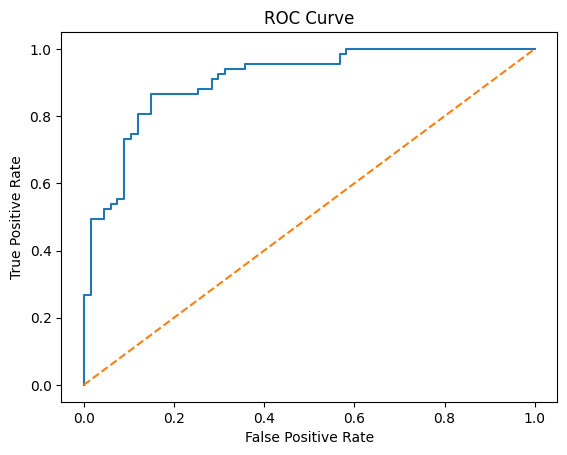

In [15]:
#METRICS
#Hold-Out Test
y_pred = model.predict(X_test_vec)
y_prob = model.predict_proba(X_test_vec)[:, 1]

#Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

#Classification Report
print(classification_report(y_test, y_pred, digits=4))

#Confusion Matrix
print(confusion_matrix(y_test, y_pred))

#ROC-AUC
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Metrics Explaination:
After downsampling the dataset to achieve equal representation of depressed and non-depressed posts, the evaluation set consisted of 134 samples:


*   Label 0 (Non-Depressed): 67
*   Label 1 (Depressed): 67

Balancing the dataset allows for more meaningful interpretation of aggregate metrics, as performance is no longer inflated by majority class dominance.


**Confusion Matrix**


|  | Predicted 0 | Predicted 1 |
|--|-------------|-------------|
| **Actual 0** | 57 (TN) | 10 (FP) |
| **Actual 1** | 9 (FN) | 58 (TP) |


Ultimately, the model is very good at detecting depressed posts but weak at detecting non depressed posts. Therefore the model is imbalanced

# Sentiment Analysis Cross Validation
Because the data in the 'Teenager' community has no origional labels, there is no way to compute the accuracy on them directly. Instead, I will cross validate with an independant method using VADER sentiment analysis. This will give a second rating of the current scores. Ideally, the depressed post should have a much more negative sentiment than the other.

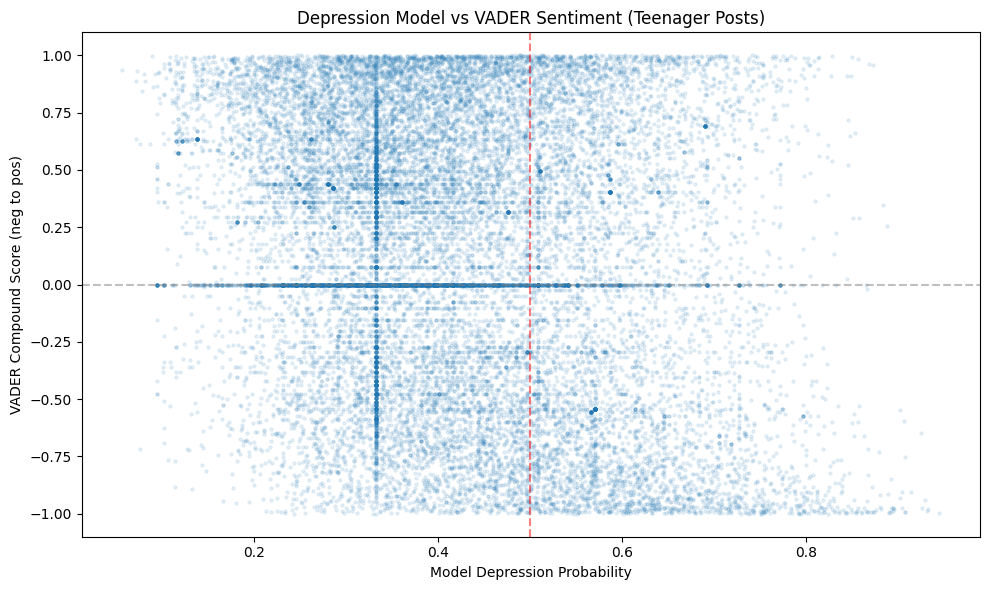

Correlation between model score and VADER: -0.2086
Agreement rate: 67.35%


In [16]:
#VADER cross-validation on teenager posts
analyzer = SentimentIntensityAnalyzer()

teen_df = teen_df.copy()
teen_df["vader_compound"] = teen_df["body"].apply(
    lambda x: analyzer.polarity_scores(str(x))["compound"]
)

#Compare VADER sentiment vs origional model's depression probability
plt.figure(figsize=(10, 6))
plt.scatter(teen_df["depression_propability"],
            teen_df["vader_compound"],
            alpha=0.1, s=5)
plt.xlabel("Model Depression Probability")
plt.ylabel("VADER Compound Score (neg to pos)")
plt.title("Depression Model vs VADER Sentiment (Teenager Posts)")
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Correlation
corr = teen_df["depression_propability"].corr(teen_df["vader_compound"])
print(f"Correlation between model score and VADER: {corr:.4f}")

#Agreement rate - model says depressed AND VADER says negative
model_depressed = teen_df["depression_propability"] > 0.5
vader_negative = teen_df["vader_compound"] < -0.05
agreement = (model_depressed == vader_negative).mean()
print(f"Agreement rate: {agreement:.2%}")

In [17]:
#Manual validation summary - top/bottom confidence
top_depressed = teen_df.nlargest(50, "depression_propability")[
    ["body", "depression_propability", "vader_compound"]
]
bottom_depressed = teen_df.nsmallest(50, "depression_propability")[
    ["body", "depression_propability", "vader_compound"]
]

print("=== TOP 50: Highest Depression Probability ===")
print(f"Mean VADER score: {top_depressed['vader_compound'].mean():.4f}")
print(f"% VADER negative: {(top_depressed['vader_compound'] < 0).mean():.0%}")
print()
print("=== BOTTOM 50: Lowest Depression Probability ===")
print(f"Mean VADER score: {bottom_depressed['vader_compound'].mean():.4f}")
print(f"% VADER positive: {(bottom_depressed['vader_compound'] > 0).mean():.0%}")

=== TOP 50: Highest Depression Probability ===
Mean VADER score: -0.7554
% VADER negative: 90%

=== BOTTOM 50: Lowest Depression Probability ===
Mean VADER score: 0.3286
% VADER positive: 54%


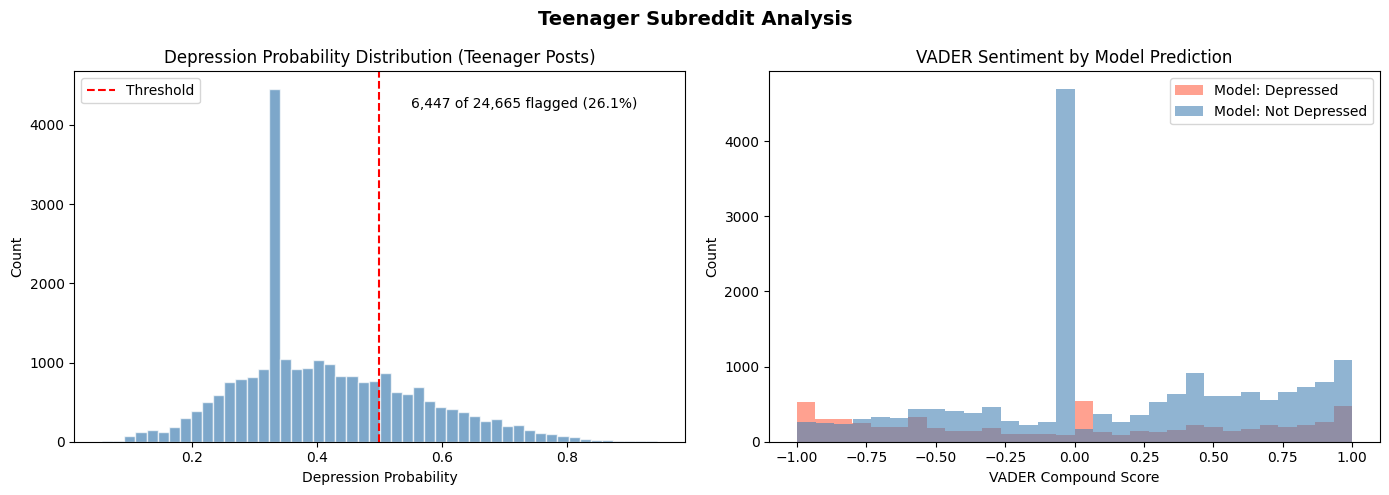

In [18]:
#Distribution of teen depression scores + VADER by prediction group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Depression probability distribution
axes[0].hist(teen_df["depression_propability"], bins=50,
             color="steelblue", alpha=0.7, edgecolor="white")
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Threshold')
axes[0].set_title("Depression Probability Distribution (Teenager Posts)")
axes[0].set_xlabel("Depression Probability")
axes[0].set_ylabel("Count")
axes[0].legend()

flagged = (teen_df["depression_propability"] > 0.5).sum()
total = len(teen_df)
axes[0].annotate(f"{flagged:,} of {total:,} flagged ({flagged/total:.1%})",
                 xy=(0.55, axes[0].get_ylim()[1]*0.9), fontsize=10)

#VADER by Model Prediction
axes[1].hist(teen_df[teen_df["depression_propability"] > 0.5]["vader_compound"],
             bins=30, alpha=0.6, label="Model: Depressed", color="tomato")
axes[1].hist(teen_df[teen_df["depression_propability"] <= 0.5]["vader_compound"],
             bins=30, alpha=0.6, label="Model: Not Depressed", color="steelblue")
axes[1].set_title("VADER Sentiment by Model Prediction")
axes[1].set_xlabel("VADER Compound Score")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.suptitle("Teenager Subreddit Analysis", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()